In [1]:
pwd

'/home/aruvi/Arush/yolov4-deepsort-master'

In [2]:
# !pip install tensorflow

In [3]:
from platform import python_version

python_version()

'3.8.10'

In [4]:
import tensorflow as tf

tf.__version__

2022-11-20 22:05:26.695363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 22:05:26.838191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-20 22:05:26.884711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 22:05:27.609170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

'2.10.0'

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
tf.test.gpu_device_name()

2022-11-20 22:05:28.619359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2022-11-20 22:05:31.398537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 1541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-11-20 22:05:31.399731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 8068 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:20:00.0, compute capability: 8.6
2022-11-20 22:05:31.400633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 8068 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:21:00.0, compute capability: 8.6
2022-11-20 22:05:31.401473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:3 with 8068 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:23:00.0, compute capability: 8.6


# Defining Config

In [7]:
class Config:
  
    TRAINING_PATH = ["./data/images/AICITY_US_train_data"]
    
    TRAINING_PATH_2 = ["./data/images/AICITY_US_train_data/91_normal.mp4"]

    TEST_PATH = ["./data/images/AICITY_US_test_data"]
    
    TEST_PATH_2 = "./data/images/AICITY_US_test_data/91_accident.mp4"

    #   SINGLE_TEST_PATH = "./data/single_test"

    SINGLE_TEST_PATH = "./data/images/AICITY_US_test_data"

    BATCH_SIZE = 3

    EPOCHS = 2

    MODEL_PATH = "./arush_model.hdf5"

    IMAGE_SIZE = 256

# Importing necessary packages

In [8]:
###IMPORTS AND DEPENDENCIES####

import tensorflow
print("Tensorflow Version: {}".format(tensorflow.__version__))
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

import cv2
import os

import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LayerNormalization

imsize = Config.IMAGE_SIZE

Tensorflow Version: 2.10.0


In [9]:
pwd

'/home/aruvi/Arush/yolov4-deepsort-master'

In [10]:
Config.TRAINING_PATH

['./data/images/AICITY_US_train_data']

In [11]:
Config.TEST_PATH

['./data/images/AICITY_US_test_data']

# Defining the Class VehicularAnomalyDetection

In [12]:
class VehicularAnomalyDetection(object):
    
    def __init__(self, output_activation = 'sigmoid', optimizer='adam', epochs=50, batch_size=32, dropout_rate=0.2,
                 l2_regularizer=0.1, preprocessing=False,
                 verbose=1, random_state=None):
        super(VehicularAnomalyDetection, self).__init__()
        
        self.output_activation = output_activation
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state
        self.verbose = verbose
        
#     def get_frames_from_video(self, video_path):
        
        
#         return
        
    def get_clips_by_stride(self, stride, frames_list, sequence_size):
        """ For data augmenting purposes.3
        Parameters
        ----------
        stride : int
            The desired distance between two consecutive frames
        frames_list : list
            A list of sorted frames of shape 128 x 128
        sequence_size: int
            The size of the desired LSTM sequence
        Returns
        -------
        list
            A list of clips , 10 frames each
        """
        clips = []
        sz = len(frames_list)
        clip = np.zeros(shape=(sequence_size, imsize, imsize, 1))
        cnt = 0
        for start in range(0, stride):
            for i in range(start, sz, stride):
                clip[cnt, :, :, 0] = frames_list[i]
                cnt = cnt + 1
                if cnt == sequence_size:
                    clips.append(clip)
                    cnt = 0
        return clips


    def get_training_set(self):
        """
        Returns
        -------
        list
            A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
        """
        #####################################
        # cache = shelve.open(Config.CACHE_PATH)
        # return cache["datasetLSTM"]
        #####################################
        clips = []
        # loop over the training folders (Train000,Train001,..)
        #all_training = [f for path in Config.DATASET_PATH for f in sorted(listdir(path))]
        all_training_paths = Config.TRAINING_PATH
        #all_training_paths.append(Config.AVENUE_DATASET_PATH)
        count = 0
        for data_file in all_training_paths:
            print("Current Data Path: {} ".format(data_file))
            for f in sorted(listdir(data_file)):
                if isdir(join(data_file, f)):
                    all_frames = []
                    # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
                    for c in sorted(listdir(join(data_file, f))):
                        if count: 
                            count = 0
                            continue
                        if str(join(join(data_file, f), c))[-3:] == "tif":
                            img = Image.open(join(join(data_file, f), c)).resize((imsize, imsize))
                        elif str(join(join(data_file, f), c)).endswith(("png","jpeg", "jpg")):
                            img = Image.open(join(join(data_file, f), c)).resize((imsize, imsize)).convert('L')
                        else: continue
                        #print(join(join(data_file, f), c))
                        img = np.array(img, dtype=np.float32) / float(256)
                        all_frames.append(img)
                        count = 1
                    # get the 10-frames sequences from the list of images after applying data augmentation
                    for stride in range(1, 3):
                        clips.extend(self.get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
        return clips
    
    def instantiate_model_and_print_summary(
        self,
        reload_model=False,
#         training = True
        ):
        """
        Parameters
        ----------
        reload_model : bool
            Load saved model or retrain it
        """
        # if not reload_model:
        #     return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
        model = Sequential()
        model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
        model.add(LayerNormalization())
        model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
        model.add(LayerNormalization())
        # # # # #
        model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
        model.add(LayerNormalization())
        model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
        model.add(LayerNormalization())
        model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
        model.add(LayerNormalization())
        # # # # #
        model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
        model.add(LayerNormalization())
        model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
        model.add(LayerNormalization())
        model.add(TimeDistributed(Conv2D(1, (11, 11), activation=self.output_activation, padding="same")))
        print(model.summary())
        return model
    
    def compile_model(self, model, loss, optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6)):
#         self.model = self.get_model()
        model.compile(loss=loss, optimizer = optimizer, metrics = ['accuracy'])
#         print(model.summary)
        return

    def fit_model(self, model, data, batch_size = 3, epochs = 50, shuffl = False):
        
#         self.input_dimx, self.input_dimy = data.shape[2], data.shape[3]
        
        model_history = model.fit(data, 
            data,
            batch_size=batch_size, 
            epochs=epochs, 
            shuffle=shuffl,
            verbose=self.verbose)
        
        return model_history
    
    def fit_on_batch(self, model, data):
        
#         self.input_dimx, self.input_dimy = data.shape[2], data.shape[3]
        
        model_history = model.train_on_batch(data, data)
        
        return model_history
    
    
#     def evaluate(self, )
        
        

# Instantiating the Class

In [13]:
anomaly_detection = VehicularAnomalyDetection()

# Getting all training images from videos

In [14]:
import time

start = time.time()
training_set = anomaly_detection.get_training_set()
end = time.time()

print("Time taken to load images from 3 videos: {}".format(end - start))

Current Data Path: ./data/images/AICITY_US_train_data 
Time taken to load images from 3 videos: 94.01419758796692


In [30]:
start2 = time.time()

training_set = np.array(training_set)
# print(training_set.shape)
training_set = training_set.reshape(-1,10,imsize,imsize,1)

end2 = time.time()
print(training_set.shape)
print("time taken to reshape the images: {}".format(end2 - start2))

(2686, 10, 256, 256, 1)
time taken to reshape the images: 6.499364376068115


# Getting 1 training video at a time

In [16]:
import time

start = time.time()
training_set_2 = anomaly_detection.get_training_set()
end = time.time()

# print("Time taken to load images from 3 videos: {}".format(end - start))

Current Data Path: ./data/images/AICITY_US_train_data 


In [17]:
print("Time taken to load images from a single video: {}".format(end - start))

Time taken to load images from a single video: 92.47070693969727


In [18]:
start2 = time.time()

training_set_2 = np.array(training_set_2)
# print(training_set.shape)
training_set_2 = training_set_2.reshape(-1,10,imsize,imsize,1)

end2 = time.time()
print(training_set_2.shape)
print("time taken to reshape the images: {}".format(end2 - start2))

(2686, 10, 256, 256, 1)
time taken to reshape the images: 5.971487760543823


In [19]:
len(training_set_2)

2686

# Initializing and training conv_lstm_autoencoder model
### conv_lstm_autoencoder is used for training on all training videos simultaneously

In [55]:
conv_lstm_autoencoder = anomaly_detection.instantiate_model_and_print_summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 10, 64, 64, 128)  15616     
 stributed)                                                      
                                                                 
 layer_normalization_14 (Lay  (None, 10, 64, 64, 128)  256       
 erNormalization)                                                
                                                                 
 time_distributed_11 (TimeDi  (None, 10, 32, 32, 64)   204864    
 stributed)                                                      
                                                                 
 layer_normalization_15 (Lay  (None, 10, 32, 32, 64)   128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 10, 32, 32, 64)   

In [56]:
anomaly_detection.compile_model(
    conv_lstm_autoencoder, 
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6),
#     metrics = ['loss', 'accuracy']
)

In [29]:
from tqdm import tqdm

n_epochs = 2
batch_size = 3

loss_history = []
acc_history = []
# history = []


def fetch_batch(train_data, batch_size, batch):
    start = batch * batch_size
    
    X_batch = train_data[start: start + batch_size, :, :, :, :]
    
    return X_batch

for epoch in range(n_epochs):
    for batch in tqdm(range(len(training_set) // batch_size)):
        X_batch = fetch_batch(training_set, batch_size, batch)
        loss, acc = conv_lstm_autoencoder.train_on_batch(X_batch, X_batch)
        loss_history.append(loss)
        acc_history.append(acc)
#     acc_history.append(acc)

  0%|                                                                                           | 0/895 [00:00<?, ?it/s]2022-11-20 22:15:31.331775: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 960.00MiB (rounded to 1006632960)requested by op sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-20 22:15:31.331918: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-20 22:15:31.331946: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 170, Chunks in use: 168. 42.5KiB allocated for chunks. 42.0KiB in use in bin. 11.5KiB client-requested in use in bin.
2022-11-20 22:15:31.331966: I tensorflow/core/common_runtime/bfc_alloc

  0%|                                                                                           | 0/895 [00:14<?, ?it/s]


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1864422/2156101163.py", line 21, in <module>
      loss, acc = conv_lstm_autoencoder.train_on_batch(X_batch, X_batch)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/rnn/time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose'
OOM when allocating tensor with shape[30,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10936]

# Initializing and training conv_lstm_autoencoder_new model
### conv_lstm_autoencoder_new is used for training on each video separately

In [90]:
conv_lstm_autoencoder_new = anomaly_detection.instantiate_model_and_print_summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 10, 64, 64, 128)  15616     
 stributed)                                                      
                                                                 
 layer_normalization_28 (Lay  (None, 10, 64, 64, 128)  256       
 erNormalization)                                                
                                                                 
 time_distributed_21 (TimeDi  (None, 10, 32, 32, 64)   204864    
 stributed)                                                      
                                                                 
 layer_normalization_29 (Lay  (None, 10, 32, 32, 64)   128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, 10, 32, 32, 64)  

In [53]:
anomaly_detection.compile_model(
    conv_lstm_autoencoder_new, 
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6),
#     metrics = ['loss', 'accuracy']
)

In [31]:
from tqdm import tqdm

n_epochs = 2
batch_size = 3

loss_history = []
acc_history = []
# history = []


def fetch_batch(train_data, batch_size, batch):
    start = batch * batch_size
    
    X_batch = train_data[start: start + batch_size, :, :, :, :]
    
    return X_batch

for epoch in range(n_epochs):
    for batch in tqdm(range(len(training_set_2) // batch_size)):
        X_batch = fetch_batch(training_set_2, batch_size, batch)
        loss, acc = conv_lstm_autoencoder_new.train_on_batch(X_batch, X_batch)
        loss_history.append(loss)
        acc_history.append(acc)
#     acc_history.append(acc)

  0%|                                                                                           | 0/895 [00:00<?, ?it/s]2022-11-20 23:27:08.252574: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 960.00MiB (rounded to 1006632960)requested by op sequential_4/time_distributed_23/conv2d_transpose_9/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-20 23:27:08.252679: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-20 23:27:08.252700: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 233, Chunks in use: 230. 58.2KiB allocated for chunks. 57.5KiB in use in bin. 17.2KiB client-requested in use in bin.
2022-11-20 23:27:08.252714: I tensorflow/core/common_runtime/bfc_alloc

  0%|                                                                                           | 0/895 [00:16<?, ?it/s]


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_4/time_distributed_23/conv2d_transpose_9/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1864422/3676458037.py", line 21, in <module>
      loss, acc = conv_lstm_autoencoder_new.train_on_batch(X_batch, X_batch)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/rnn/time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential_4/time_distributed_23/conv2d_transpose_9/conv2d_transpose'
OOM when allocating tensor with shape[30,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_4/time_distributed_23/conv2d_transpose_9/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18752]

In [54]:
# conv_lstm_autoencoder_new.save('./models/conv_lstm_autoencoder_new.h5')

In [20]:
anomaly_detection.compile_model(
    conv_lstm_autoencoder_new, 
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6),
#     metrics = ['loss', 'accuracy']
)

In [32]:
import time

start = time.time()
testing_set_2 = get_testing_set()
end = time.time()


In [33]:
testing_set_2 = np.array(testing_set_2)
testing_set_2 = testing_set_2.reshape(-1,10,imsize,imsize,1)

print(testing_set_2.shape)

In [21]:
from tqdm import tqdm

n_epochs = 2
batch_size = 3

loss_history = []
acc_history = []
# history = []


def fetch_batch(train_data, batch_size, batch):
    start = batch * batch_size
    
    X_batch = train_data[start: start + batch_size, :, :, :, :]
    
    return X_batch

for epoch in range(n_epochs):
    for batch in tqdm(range(len(training_set_2) // batch_size)):
        X_batch = fetch_batch(training_set_2, batch_size, batch)
        loss, acc = conv_lstm_autoencoder_new.train_on_batch(X_batch, X_batch)
        loss_history.append(loss)
#         acc_history.append(acc)
#     acc_history.append(acc)

  0%|                                                                                           | 0/895 [00:00<?, ?it/s]2022-11-15 17:48:59.208739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-15 17:49:00.103590: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|█████████████████████████████████████████████████████████████████████████████████| 895/895 [08:53<00:00,  1.68it/s]


In [24]:
def fetch_batch(test_data, batch_size, batch):
    start = batch * batch_size
    
    X_batch = test_data[start: start + batch_size, :, :, :, :]
    
    return X_batch

for epoch in range(n_epochs):
    for batch in tqdm(range(len(testing_set_2) // batch_size)):
        X_batch = fetch_batch(testing_set_2, batch_size, batch)
        loss, acc = conv_lstm_autoencoder_new.predict_on_batch(X_batch, X_batch)
        loss_history.append(loss)

NameError: name 'testing_set_2' is not defined

In [66]:
conv_lstm_autoencoder.save('./models/conv_lstm_autoencoder.h5')

In [22]:
conv_lstm_autoencoder_new.save('./models/conv_lstm_autoencoder2.h5')

In [23]:
len(acc_history)

0

<AxesSubplot: >

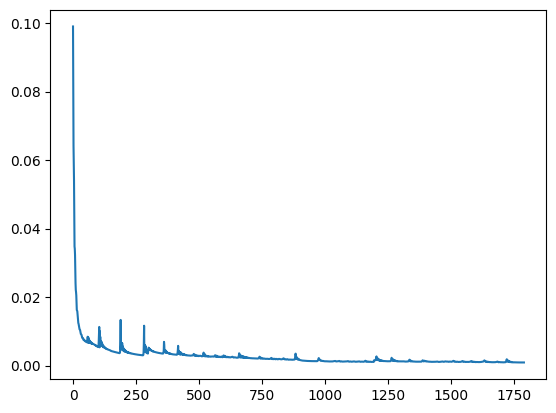

In [24]:
import pandas as pd

pd.Series(loss_history).plot()

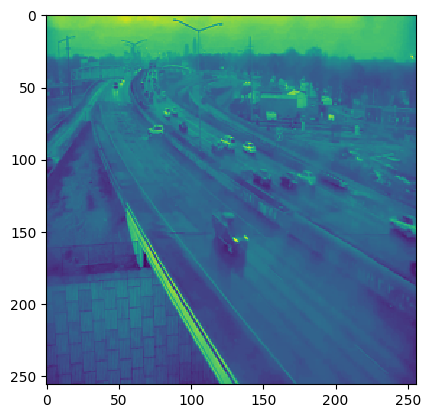

In [38]:
ip_image = training_set[300:303][0][0]

from matplotlib import pyplot as plt
plt.imshow(ip_image, interpolation='nearest')
plt.show()

In [28]:
actual_models_predicted_image = conv_lstm_autoencoder.predict(training_set[:3])[0][0]

from matplotlib import pyplot as plt
plt.imshow(actual_models_predicted_image, interpolation='nearest')
plt.show()

2022-11-20 22:14:55.696453: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 967.51MiB (rounded to 1014512640)requested by op sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-20 22:14:55.696518: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-20 22:14:55.696545: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 133, Chunks in use: 133. 33.2KiB allocated for chunks. 33.2KiB in use in bin. 11.4KiB client-requested in use in bin.
2022-11-20 22:14:55.696554: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 28, Chunks in use: 28. 14.0KiB allocated for chunks. 14.0KiB in use in bin. 14.0

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1864422/2569169499.py", line 1, in <module>
      actual_models_predicted_image = conv_lstm_autoencoder.predict(training_set[:3])[0][0]
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/rnn/time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "/home/aruvi/Arushenv/lib/python3.8/site-packages/keras/backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose'
OOM when allocating tensor with shape[30,257,257,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/time_distributed_18/conv2d_transpose_7/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_7196]

In [48]:
# actual_models_predicted_image = conv_lstm_autoencoder.predict(training_set[60:63])[0][0]

# from matplotlib import pyplot as plt
# plt.figure()
# # plt.imshow(training_set[0][0], interpolation='nearest')
# plt.imshow(actual_models_predicted_image, interpolation='nearest')
# plt.show()

1/1 [==============================] - 0s 73ms/step


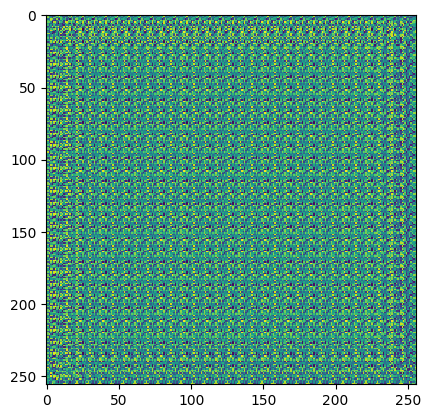

In [85]:
random_models_predicted_image = conv_lstm_autoencoder_new.predict(training_set[:3])[0][0]

from matplotlib import pyplot as plt
plt.imshow(random_models_predicted_image, interpolation='nearest')
plt.show()

In [20]:
conv_lstm_autoencoder = load_model('./models/conv_lstm_autoencoder.h5')

2022-11-20 22:13:02.854467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-11-20 22:13:02.855486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8068 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:20:00.0, compute capability: 8.6
2022-11-20 22:13:02.856452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 8068 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:21:00.0, compute capability: 8.6
2022-11-20 22:13:02.857399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 8068 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3080, pc

In [21]:
conv_lstm_autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 64, 64, 128)  15616     
 stributed)                                                      
                                                                 
 layer_normalization_21 (Lay  (None, 10, 64, 64, 128)  256       
 erNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 32, 32, 64)   204864    
 stributed)                                                      
                                                                 
 layer_normalization_22 (Lay  (None, 10, 32, 32, 64)   128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 10, 32, 32, 64)   

In [22]:
conv_lstm_autoencoder_new = load_model('./models/conv_lstm_autoencoder_new.h5')

In [23]:
conv_lstm_autoencoder_new.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 10, 64, 64, 128)  15616     
 stributed)                                                      
                                                                 
 layer_normalization_28 (Lay  (None, 10, 64, 64, 128)  256       
 erNormalization)                                                
                                                                 
 time_distributed_21 (TimeDi  (None, 10, 32, 32, 64)   204864    
 stributed)                                                      
                                                                 
 layer_normalization_29 (Lay  (None, 10, 32, 32, 64)   128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, 10, 32, 32, 64)  

In [93]:
def get_single_test(test_path):
    sz = 100
    test = np.zeros(shape=(sz, imsize, imsize, 1))
    cnt = 0
    for f in sorted(listdir(test_path)):
        if str(join(test_path, f))[-3:] =="jpg":
            img = Image.open(join(test_path, f)).resize((imsize, imsize))
            img = np.array(img, dtype=np.float32) / float(256)
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [94]:
def evaluate(given_model, path):
    model = given_model
    print("got model")
    test = get_single_test(path)
    print(test.shape)
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, imsize, imsize, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, imsize, imsize, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    
    # Reconstruction of the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
    print(reconstructed_sequences)
    #Sequences Reconstruction Cost e(x,y,sz)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [66]:
evaluate(conv_lstm_autoencoder, Config.SINGLE_TEST_PATH)

got model
(100, 256, 256, 1)


2022-11-20 21:20:38.956491: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 225.00MiB (rounded to 235929600)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-20 21:20:38.956580: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-20 21:20:38.956607: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 182, Chunks in use: 181. 45.5KiB allocated for chunks. 45.2KiB in use in bin. 22.4KiB client-requested in use in bin.
2022-11-20 21:20:38.956626: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 56, Chunks in use: 56. 28.2KiB allocated for chunks. 28.2KiB in use in bin. 28.0KiB client-requested in use in bin.
2022-11-20 21:20:38.95

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ze 294912 next 100
2022-11-20 21:20:38.958747: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc08223a100 of size 294912 next 28
2022-11-20 21:20:38.958758: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082282100 of size 589824 next 10
2022-11-20 21:20:38.958769: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082312100 of size 409600 next 34
2022-11-20 21:20:38.958780: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082376100 of size 61952 next 25
2022-11-20 21:20:38.958792: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082385300 of size 256 next 52
2022-11-20 21:20:38.958842: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082385400 of size 256 next 53
2022-11-20 21:20:38.958859: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc082385500 of size 393216 next 57
2022-11-20 21:20:38.958871: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] I

2022-11-20 21:20:38.960379: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc08502f200 of size 256 next 364
2022-11-20 21:20:38.960389: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] Free  at 7fc08502f300 of size 256 next 361
2022-11-20 21:20:38.960400: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc08502f400 of size 512 next 328
2022-11-20 21:20:38.960411: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc08502f600 of size 1024 next 327
2022-11-20 21:20:38.960421: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] Free  at 7fc08502fa00 of size 32000 next 238
2022-11-20 21:20:38.960432: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc085037700 of size 512 next 247
2022-11-20 21:20:38.960442: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc085037900 of size 1024 next 245
2022-11-20 21:20:38.960453: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fc085037d00 o

In [27]:
training_set_2.shape

(2686, 10, 256, 256, 1)

In [ ]:
evaluate(conv_lstm_autoencoder_new, Config.SINGLE_TEST_PATH)

got model
(100, 256, 256, 1)


In [72]:
conv_lstm_new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 64, 64, 128)  15616     
 stributed)                                                      
                                                                 
 layer_normalization_21 (Lay  (None, 10, 64, 64, 128)  256       
 erNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 32, 32, 64)   204864    
 stributed)                                                      
                                                                 
 layer_normalization_22 (Lay  (None, 10, 32, 32, 64)   128       
 erNormalization)                                                
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, 10, 32, 32, 64)   

In [55]:

def get_model(
    # reload_model=False
    ):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    # if not reload_model:
    #     return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    model = Sequential()
    model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    model.add(LayerNormalization())
    # # # # #
    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    # # # # #
    model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(model.summary())
    return model

In [8]:
training_set = get_training_set()
training_set = np.array(training_set)
# print(training_set.shape)
training_set = training_set.reshape(-1,10,imsize,imsize,1)
print(training_set.shape)

Current Data Path: ./data/images 
(26, 10, 256, 256, 1)


In [30]:
model = get_model()

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6))

model.fit(training_set, 
            training_set,
            batch_size=3, 
            epochs=2,
            shuffle=False)

model.save(Config.MODEL_PATH)

NameError: name 'get_model' is not defined

In [25]:
model.fit(training_set, 
            training_set,
            # batch_size=Config.BATCH_SIZE, 
            # epochs=Config.EPOCHS, 
            verbose = 1,
            shuffle=False)
model.save(Config.MODEL_PATH)

In [22]:
training_set_copy = training_set.copy()
print(training_set_copy.shape)

(26, 10, 256, 256, 1)


In [23]:
training_set_copy = training_set_copy.reshape(-1, 256, 256, 1)
# training_set_copy = training_set_copy.reshape(-1, 256, 256)

In [24]:
print(training_set_copy.shape)

(260, 256, 256, 1)


In [25]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(256, 256, 1)) 

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       147584

In [27]:
autoencoder.fit(training_set_copy, training_set_copy)

9/9 [==============================] - 30s 3s/step - loss: 0.6875


In [48]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, imsize, imsize, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] =="jpg":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((imisze, imsize))
            img = np.array(img, dtype=np.float32) / float(256)
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [49]:
def evaluate(trained_model):
    model = trained_model
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, imsize, imsize, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, imsize, imsize, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    
    # Reconstruction of the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
#     print(reconstructed_sequences)
    #Sequences Reconstruction Cost e(x,y,sz)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

got model
(200, 256, 256, 1)
64/64 [==============================] - 14s 223ms/step


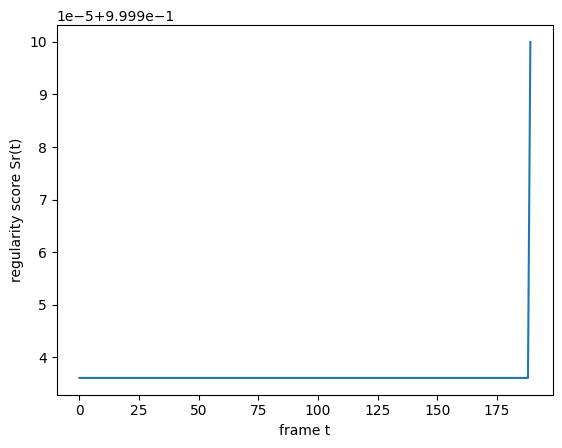

In [50]:
evaluate(conv_lstm_autoencoder)